# 개요 
* 딥러닝 스터디에 제출했던 과제에 대한 피드백 반영 및 개선(지속 개선예정)
* 원본데이터 : [Kaggle CreditCard Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)
* 적용한 피드백
  * 데이터셋 비율 : Train, Validation, Test를 8:1:1로 반영
  * Scikit learn의 train_test_split에 stratify옵션으로 Label비중 조정
  * 기본 f1-score가 아닌 weighted f1-score로 metric 반영
* 추가 테스트
  * StratifiedKFold 적용 전과 후를 기초적인 Neural Network모델로 비교
* 결과
  * 분류문제에 대해 StratifiedKFold 적용으로 모델개선됨을 확인함
  * 단순 f1-score일때는 30점 초반대에서 여러 파라미터 조정을 해도 변경이 없었으나,
    weighted f1-score 적용 후 파라미터 조정에 따라 점수가 상승되었음.
    (이상거래 데이터처럼 편중된 경우에는 단순 f1-score는 성능확인에 부적합할 수 있음)

# 개선과제 진행

## 데이터 확인
* 전체 데이터 : Null값 없음을 확인
  * Time 컬럼 : 첫번째 거래와의 단순 시간차이이므로 삭제 예정
  * V1 ~ V28 컬럼 : 익명화된 데이터. 전부 사용
  * Amount 컬럼
    * 특이사항 : 결제액이 0인 데이터가 있어, 월정액 등록 전 Validation용 결제가 아닐까 추정
    * 이상거래(Class 1)도 데이터로 포함되어있지만, 실질적 돈 이동이 없어 의미가 있는지 의문
      * 위 이유로 처음에는 결제액 0인 데이터를 제거할까 고민
      * 몇 없는 이상거래 데이터이므로 유지하는 것으로 결정 (전체 492개 이상거래 중 27건 제거시 약 5%의 데이터 손실)
  * Class 컬럼
    * 특이사항 : 98%가 정상거래(Class 0)인 데이터로 편중이 심함
    * 데이터가 Imbalance한 경우, Accuracy는 성능측정에 한계가 있으므로, `F1-Score`를 사용

In [ ]:
import pandas as pd
import sqlite3

conn = sqlite3.connect('creditcard.db')
df = pd.read_sql_query("SELECT * FROM creditcard", conn)
conn.close()
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [ ]:
# df.info()를 통한 null값 및 컬럼 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
# Class데이터 : 일반거래(0)와 이상거래(1) 건수
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [ ]:
# Class데이터 : 일반거래(0)와 이상거래(1) 비중
df[df['Amount']==0]['Class'].value_counts(normalize=True)

Class
0    0.985205
1    0.014795
Name: proportion, dtype: float64

In [ ]:
# Amount = 0인 데이터
df[df['Amount']==0]['Class'].value_counts()

Class
0    1798
1      27
Name: count, dtype: int64

In [ ]:
# t-sne 구현 샘플 (분류 분포를 확인해보고자 했으나, 차원 및 데이터가 많아서인지 너무 오래걸려서 코드만 보존)
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Assume we have a high-dimensional dataset X
X = df[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']]

# Create a t-SNE model with 2 components (for 2D visualization)
tsne = TSNE(n_components=2, random_state=0)

# Fit and transform the data
X_tsne = tsne.fit_transform(X)

# Visualize the results
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.show()

## 데이터셋 구성

### 불필요한 컬럼 제거 및 X, Y 분할

In [ ]:
df_x = df.drop(['Time', 'Class'], axis=1).copy()
df_y = df['Class'].copy()

df_x.shape, df_y.shape

((284807, 29), (284807,))

### Train, Validation, Test 데이터 나누기(stratify옵션 비교, 학습에 미사용)
* Label 비율을 맞추는 stratify옵션에 따른 Label값 수 확인 
* 단순히 Train, Validation, Test를 나누는 것과, kfold로 나누고 모델링에서 비교해볼 예정
  * 비율은 Train, Validation, Test 8:1:1 가깝게 설정
* Scikit learn의 train_test_split 사용
* **Test data에서 약간의 차이가 있었다 (미적용시 40, 적용시 49)**

In [ ]:
# stratify 미적용

from sklearn.model_selection import train_test_split

x_train, x_test, ty_train, y_test = train_test_split(df_x, df_y, test_size=0.1)

print(f"{x_train.shape}, {x_test.shape}")
print(f"{y_train.shape}, {y_test.shape}")
print()
print(f"y_train {y_train.value_counts()}")
print(f"y_test {y_test.value_counts()}")

(256326, 29), (28481, 29)
(256326,), (28481,)

y_train Class
0    255883
1       443
Name: count, dtype: int64
y_test Class
0    28441
1       40
Name: count, dtype: int64


In [ ]:
# stratify 적용

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.1, stratify=df_y)

print(f"{x_train.shape}, {x_test.shape}")
print(f"{y_train.shape}, {y_test.shape}")
print()
print(f"y_train {y_train.value_counts()}")
print(f"y_test {y_test.value_counts()}")

(256326, 29), (28481, 29)
(256326,), (28481,)

y_train Class
0    255883
1       443
Name: count, dtype: int64
y_test Class
0    28432
1       49
Name: count, dtype: int64


### Train, Validation, Test 나누기(학습에 사용)
* Test set 먼저 분리하여, 이후 평가에서 공통적으로 사용
* Train, Validation은 각각 다른 방법으로 나누어 사용

#### Test set 나누기(공통)
* 단순히 비율로 나눈 데이터셋의 변수명
  * x_train_2, x_validation_2, x_test
  * y_train_2, y_validation_2, y_test

In [ ]:
# Train, Test 나누기
from sklearn.model_selection import train_test_split

# stratify 적용
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.1, stratify=df_y)

print(f"{x_train.shape}, {x_test.shape}")
print(f"{y_train.shape}, {y_test.shape}")
print()
print(f"y_train {y_train.value_counts()}")
print(f"y_test {y_test.value_counts()}")

(256326, 29), (28481, 29)
(256326,), (28481,)

y_train Class
0    255883
1       443
Name: count, dtype: int64
y_test Class
0    28432
1       49
Name: count, dtype: int64


#### Train, Validation 나누기(단순히 비율만 고려)
* 단순히 비율로 나눈 데이터셋의 변수명
  * x_train_2, x_validation_2, x_test
  * y_train_2, y_validation_2, y_test

In [ ]:
# Train, Validation 나누기
x_train_2, x_validation_2, y_train_2, y_validation_2 = train_test_split(x_train, y_train, test_size=1/9, stratify=y_train)
print(f"{x_train_2.shape}, {x_validation_2.shape}")
print(f"{y_train_2.shape}, {y_validation_2.shape}")
print()
print(f"y_train {y_train_2.value_counts()}")
print(f"validation {y_validation_2.value_counts()}")

(227845, 29), (28481, 29)
(227845,), (28481,)

y_train Class
0    227451
1       394
Name: count, dtype: int64
validation Class
0    28432
1       49
Name: count, dtype: int64


#### Train, Validation 나누기(StratifiedKFold적용)
* 분류문제인 경우 StratifiedKFold 적용, 회귀인 경우에는 사용하지 않음
* StratifiedKFold 적용 데이터셋의 변수명
  * kfold_dataset[idx]['x_train'], kfold_dataset[idx]['x_validation'], x_test
  * kfold_dataset[idx]['y_train'], kfold_dataset[idx]['y_validation'], y_test

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Train, Validation 나누기
kfold_dataset = {}

s_kfold = StratifiedKFold(n_splits=9)
for i, (train_index, validation_index) in enumerate(s_kfold.split(x_train, y_train)):
    kfold_dataset[i] = {'x_train': x_train.iloc[train_index], # Scaler 적용시 .iloc삭제
                        'y_train': y_train.iloc[train_index], # Scaler 적용시 .iloc삭제
                        'x_validation' : x_train.iloc[validation_index], # Scaler 적용시 .iloc삭제
                        'y_validation' : y_train.iloc[validation_index]  # Scaler 적용시 .iloc삭제
                        }
    
for idx in kfold_dataset.keys():
    print(f"Train set{idx} : {kfold_dataset[idx]['x_train'].shape}, {kfold_dataset[idx]['y_train'].shape}")
    print(f"Validation set{idx} : {kfold_dataset[idx]['x_validation'].shape}, {kfold_dataset[idx]['y_validation'].shape}")
    print()

Train set0 : (227845, 29), (227845,)
Validation set0 : (28481, 29), (28481,)

Train set1 : (227845, 29), (227845,)
Validation set1 : (28481, 29), (28481,)

Train set2 : (227845, 29), (227845,)
Validation set2 : (28481, 29), (28481,)

Train set3 : (227845, 29), (227845,)
Validation set3 : (28481, 29), (28481,)

Train set4 : (227845, 29), (227845,)
Validation set4 : (28481, 29), (28481,)

Train set5 : (227845, 29), (227845,)
Validation set5 : (28481, 29), (28481,)

Train set6 : (227846, 29), (227846,)
Validation set6 : (28480, 29), (28480,)

Train set7 : (227846, 29), (227846,)
Validation set7 : (28480, 29), (28480,)

Train set8 : (227846, 29), (227846,)
Validation set8 : (28480, 29), (28480,)



## 모델 구성
* 기존에 f1 score를 위해 사용하려던 tensorflow_addons는 개발종료되어 다른 패키지로 대체
* 단순 f1 score가 아닌 weighted f1 score사용

### 기초 딥러닝 모델(비율로 단순히 나눈 데이터셋 vs StratifiedKFold 비교)

#### 딥러닝 모델(StratifiedKFold 미적용)

In [ ]:
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall, F1Score
import matplotlib.pyplot as plt
%matplotlib inline

# 모델링
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((29,1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid') # 또는 2, Softmax 사용가능
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[F1Score(average="weighted"), Precision(), Recall()])

# 학습 및 평가
## 모델 학습
model_history = model.fit(x_train_2, y_train_2, 
                    epochs=10, verbose=0,
                    validation_data=(x_validation_2, y_validation_2))

## 모델 평가
print('* 모델평가')
result_train = model.evaluate(x_train_2, y_train_2, verbose=2)
result_validate = model.evaluate(x_test, y_test, verbose=2)

* 모델평가
7121/7121 - 4s - 562us/step - f1_score: 0.0035 - loss: 0.0041 - precision_6: 0.9545 - recall_6: 0.7462
891/891 - 1s - 568us/step - f1_score: 0.0035 - loss: 0.0037 - precision_6: 0.9211 - recall_6: 0.7143


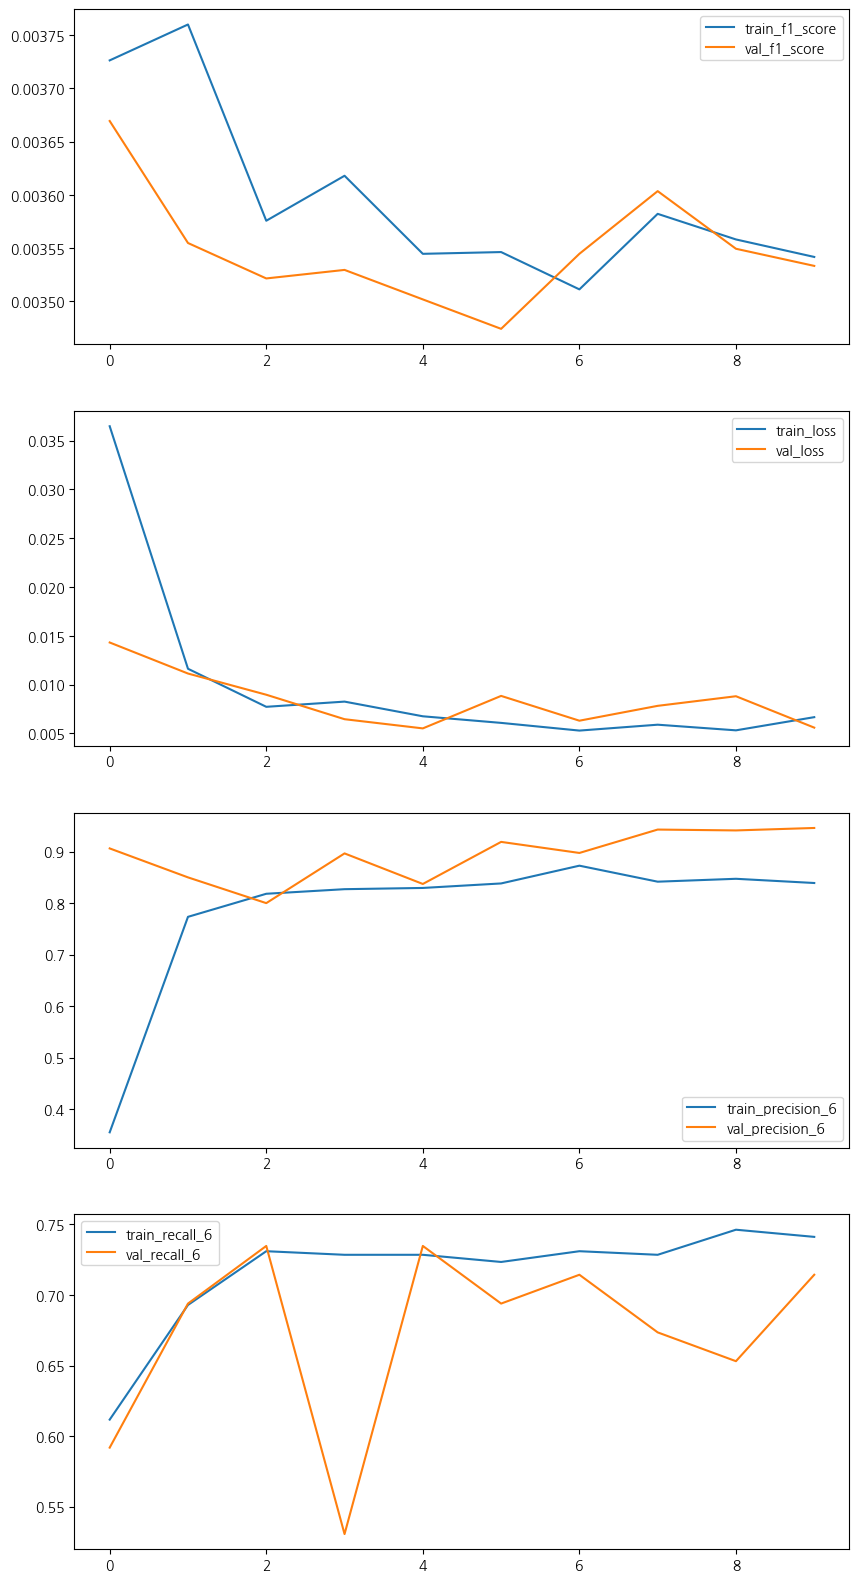

In [ ]:
# 시각화 (Train, Validation score)
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(10,20))

for idx, key in enumerate(model_history.history.keys()):
    if idx == 4:
        break
    axs[idx].plot(model_history.history[key], label=f"train_{key}")
    axs[idx].plot(model_history.history[f"val_{key}"], label=f"val_{key}")
    axs[idx].legend()

plt.show()

#### 딥러닝 모델(StratifiedKFold 적용)

In [ ]:
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall, F1Score
import matplotlib.pyplot as plt
%matplotlib inline

# 모델링
model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Input((29,1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid') # 또는 2, Softmax 사용가능
])

model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[F1Score(average="weighted"), Precision(), Recall()])

# 학습 및 평가
kfold_result_train = {}
kfold_result_validate = {}
kfold_model_history = {}

for idx in kfold_dataset.keys():
    ## 모델 학습
    kfold_model_history[idx] = model_2.fit(kfold_dataset[idx]['x_train'],  kfold_dataset[idx]['y_train'], 
                        epochs=10, verbose=0,
                        validation_data=(kfold_dataset[idx]['x_validation'], kfold_dataset[idx]['y_validation']))

    ## 모델 평가
    print(f'* 모델평가_{idx}')
    kfold_result_train[idx] = model_2.evaluate(kfold_dataset[idx]['x_train'],kfold_dataset[idx]['y_train'], verbose=2)
    kfold_result_validate[idx] = model_2.evaluate(x_test, y_test, verbose=2)

* 모델평가_0
7121/7121 - 4s - 574us/step - f1_score: 0.0037 - loss: 0.0081 - precision_7: 0.8941 - recall_7: 0.7284
891/891 - 1s - 583us/step - f1_score: 0.0037 - loss: 0.0059 - precision_7: 0.8421 - recall_7: 0.6531
* 모델평가_1
7121/7121 - 4s - 570us/step - f1_score: 0.0039 - loss: 0.0065 - precision_7: 0.9078 - recall_7: 0.7995
891/891 - 1s - 590us/step - f1_score: 0.0038 - loss: 0.0053 - precision_7: 0.9000 - recall_7: 0.7347
* 모델평가_2
7121/7121 - 4s - 579us/step - f1_score: 0.0042 - loss: 0.0053 - precision_7: 0.9050 - recall_7: 0.8223
891/891 - 1s - 603us/step - f1_score: 0.0042 - loss: 0.0047 - precision_7: 0.9024 - recall_7: 0.7551
* 모델평가_3
7121/7121 - 4s - 574us/step - f1_score: 0.0046 - loss: 0.0048 - precision_7: 0.9440 - recall_7: 0.8122
891/891 - 1s - 595us/step - f1_score: 0.0045 - loss: 0.0054 - precision_7: 0.8974 - recall_7: 0.7143
* 모델평가_4
7121/7121 - 4s - 574us/step - f1_score: 0.0048 - loss: 0.0066 - precision_7: 0.9493 - recall_7: 0.8092
891/891 - 1s - 601us/step - f1_score

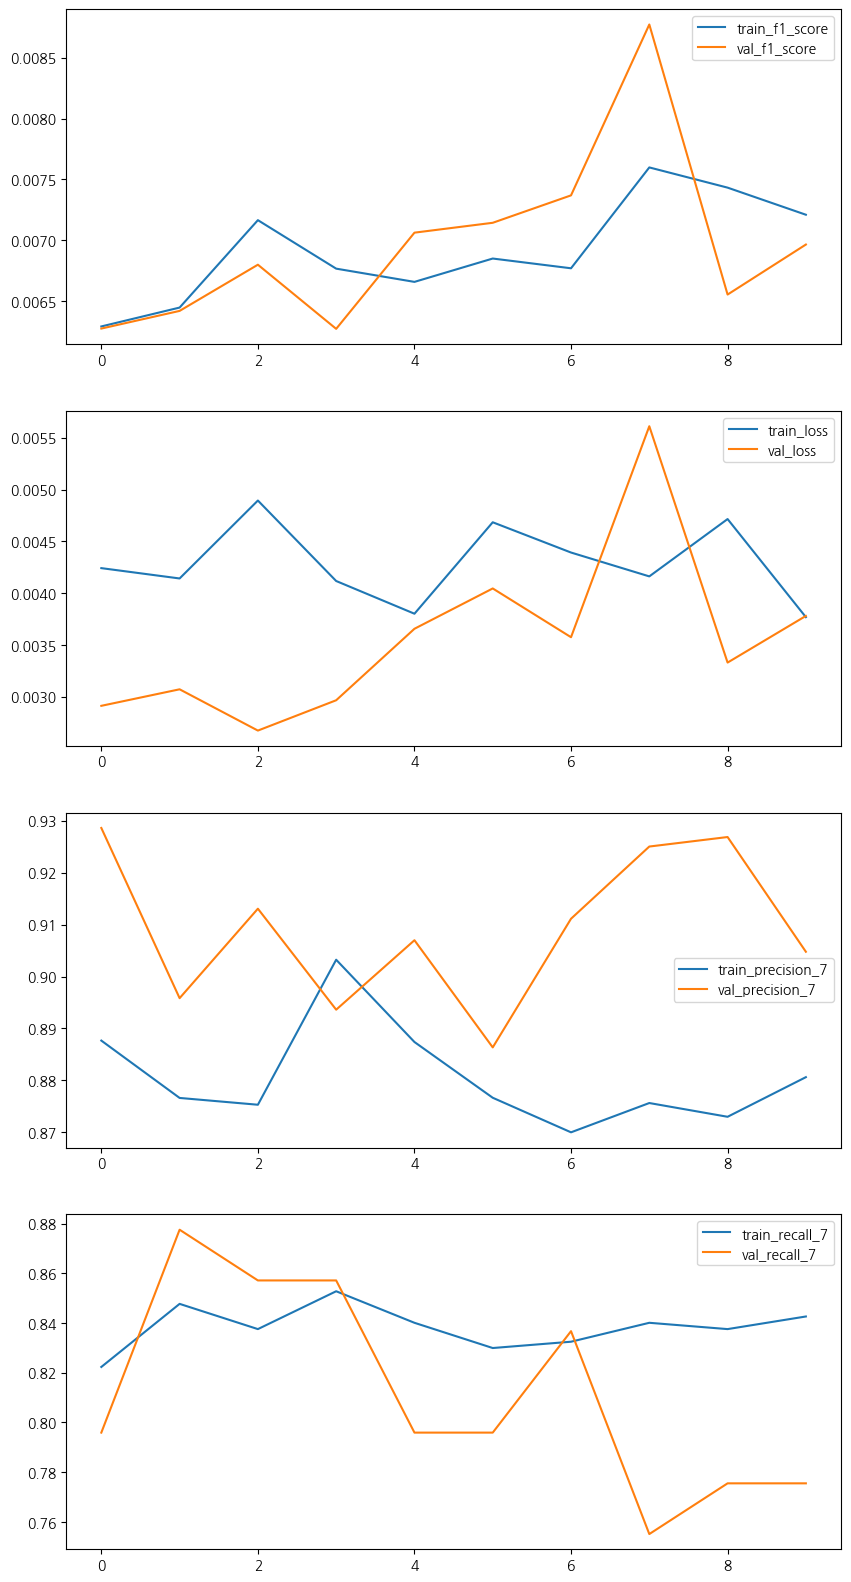

In [ ]:
# 시각화
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(10,20))

for idx, key in enumerate(kfold_model_history[8].history.keys()):
    if idx == 4:
        break
    axs[idx].plot(kfold_model_history[8].history[key], label=f"train_{key}")
    axs[idx].plot(kfold_model_history[8].history[f"val_{key}"], label=f"val_{key}")
    axs[idx].legend()

plt.show()

#### StratifiedKFold 적용유무에 따른 수치 비교
* 적용 후 Precision을 제외한 Test지표 향상됨
  * 모델평가(적용X)
    * 7121/7121 - 4s - 562us/step - f1_score: 0.0035 - loss: 0.0041 - precision_6: 0.9545 - recall_6: 0.7462
    * 891/891 - 1s - 568us/step - f1_score: 0.0035 - loss: 0.0037 - precision_6: 0.9211 - recall_6: 0.7143
  * 모델평가(적용O)
    * 7121/7121 - 4s - 573us/step - f1_score: 0.0071 - loss: 0.0024 - precision_7: 0.9479 - recall_7: 0.8782
    * 891/891 - 1s - 598us/step - f1_score: 0.0072 - loss: 0.0033 - precision_7: 0.9000 - recall_7: 0.7347

* 적용 후 Precision을 제외한 Train, Validation지표 향상

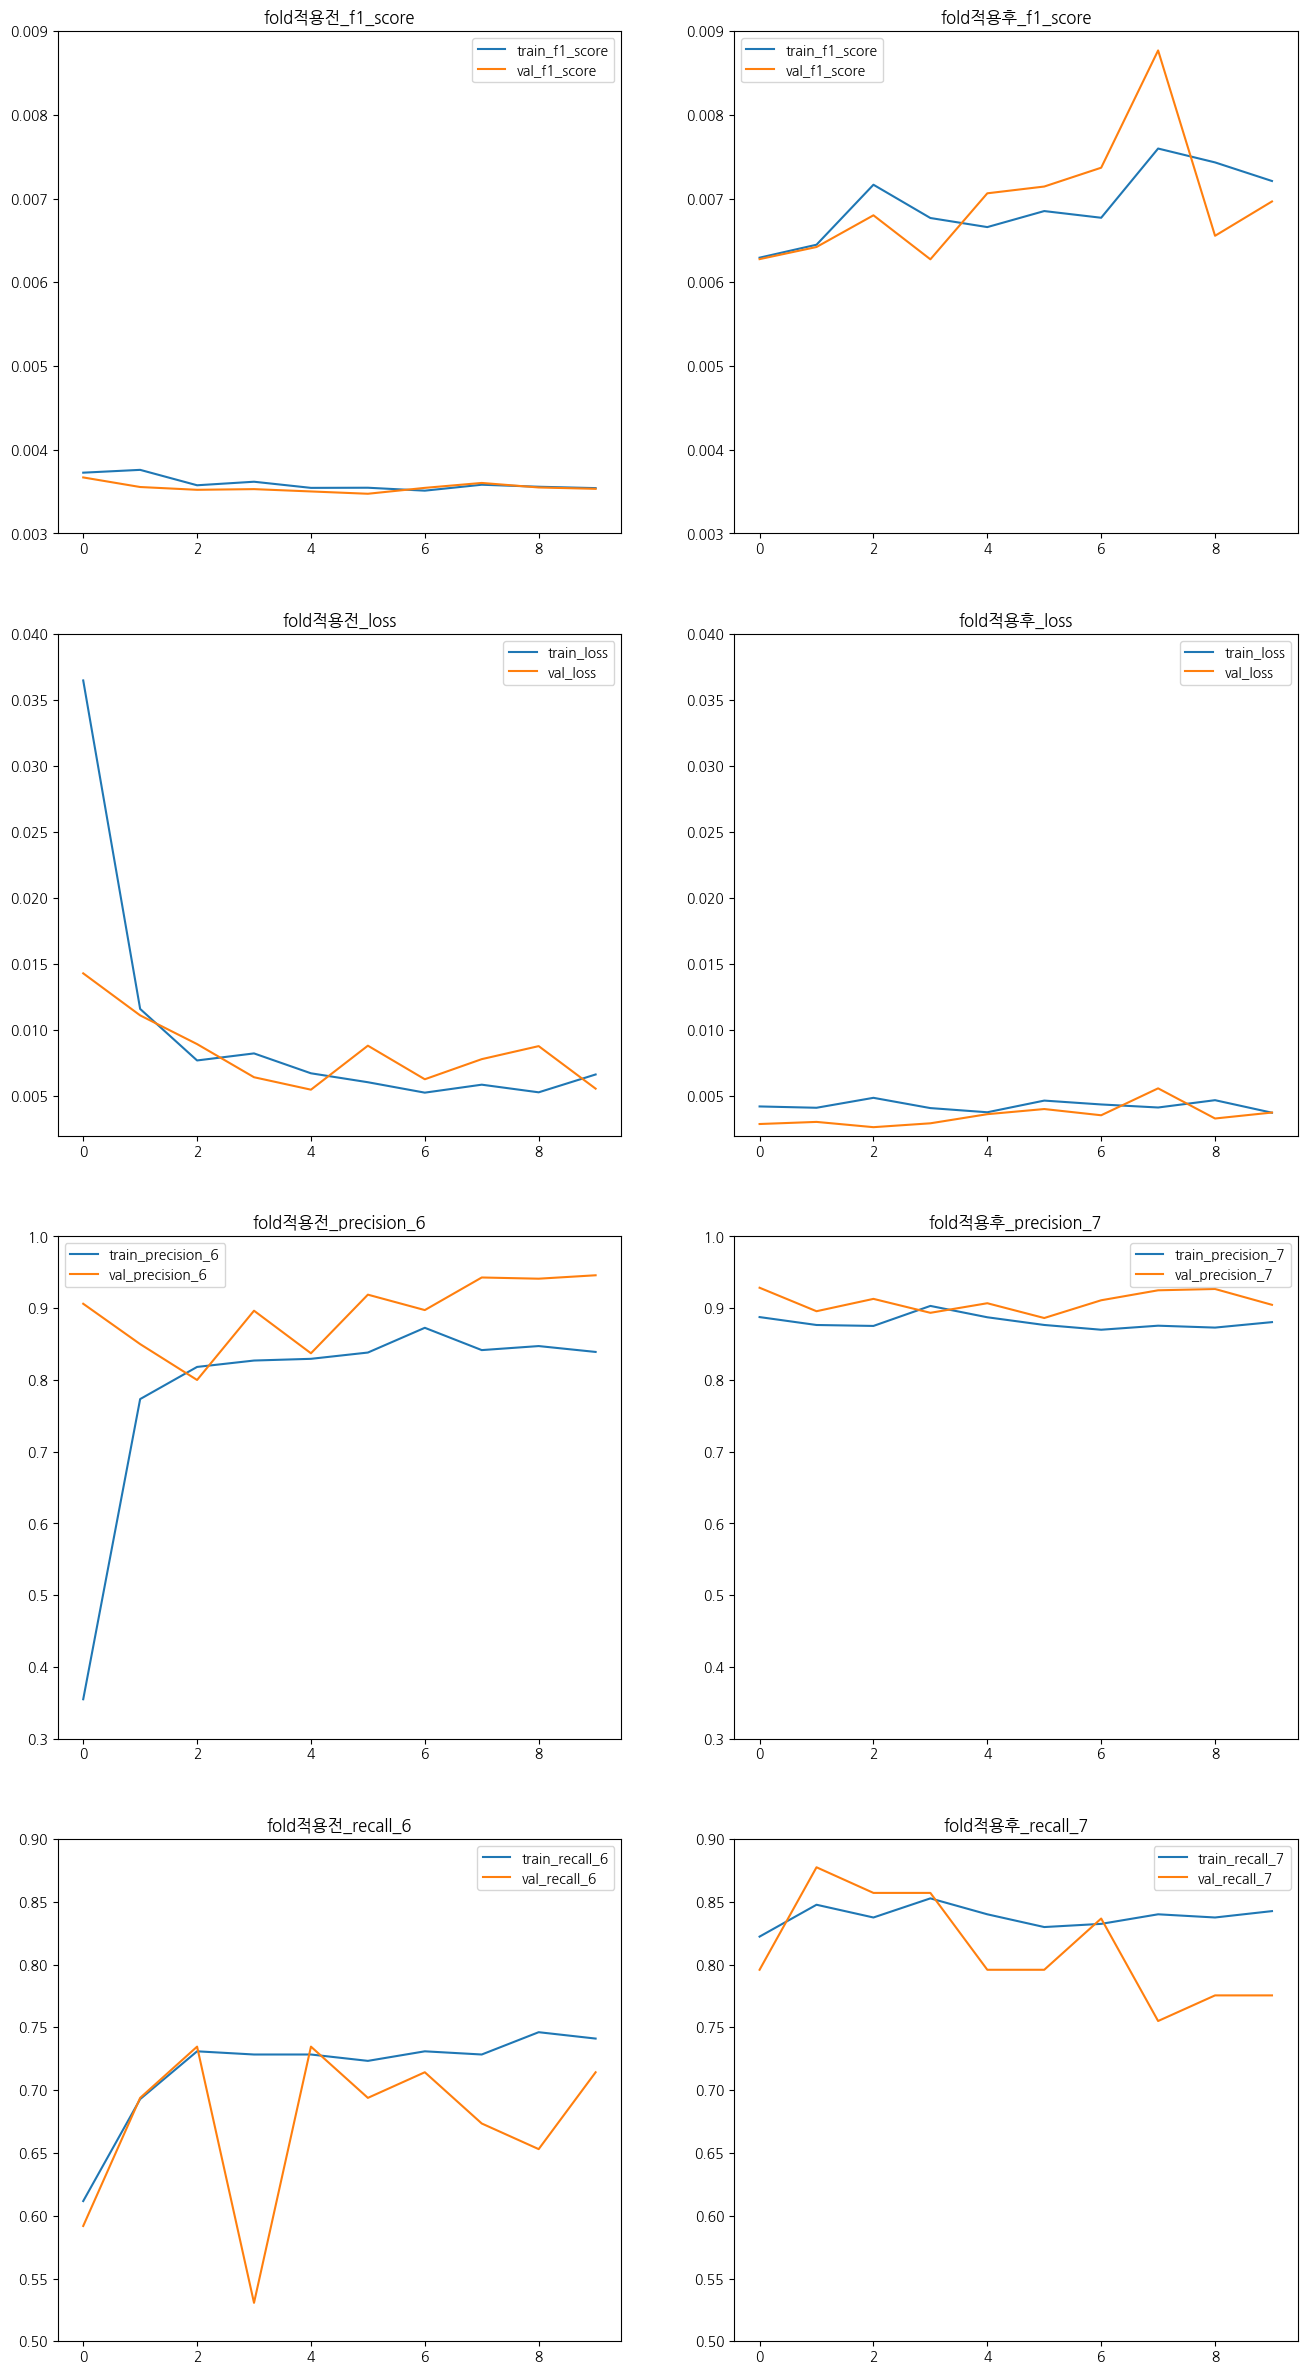

In [ ]:
import koreanize_matplotlib

# 시각화
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(16,30))

# 그래프간 비교를 위해, y축 고정을 위한 최대/최소값 계산
graph_min = {'f1_score':0.003,
'loss':0.002,
'precision':0.3,
'recall':0.5}
graph_max = {'f1_score':0.009,
'loss':0.04,
'precision':1,
'recall':0.9}


# 그래프1
for idx, key in enumerate(model_history.history.keys()):
    if idx == 4:
        break
    axs[idx, 0].plot(model_history.history[key], label=f"train_{key}")
    axs[idx, 0].plot(model_history.history[f"val_{key}"], label=f"val_{key}")
    axs[idx, 0].set_title(f"fold적용전_{key}")
    axs[idx, 0].set_ylim([graph_min[key.replace('_6','').replace('_7','')], graph_max[key.replace('_6','').replace('_7','')] ])
    axs[idx, 0].legend()

# 그래프2
for idx, key in enumerate(kfold_model_history[8].history.keys()):
    if idx == 4:
        break

    axs[idx, 1].plot(kfold_model_history[8].history[key], label=f"train_{key}")
    axs[idx, 1].plot(kfold_model_history[8].history[f"val_{key}"], label=f"val_{key}")
    axs[idx, 1].set_title(f"fold적용후_{key}")
    axs[idx, 1].set_ylim([graph_min[key.replace('_6','').replace('_7','')], graph_max[key.replace('_6','').replace('_7','')]])
    axs[idx, 1].legend()

plt.show()